## ResNet50 - BGR

## ResNet50 - RGB

## ResNet50 - RGB & Data Preprocessed

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_bgr = cv2.imread(image_path)
            
            # 노이즈 제거
            image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # YUV 컬로 포맷으로 변환
            image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # 히스토그램 평활화 적용
            image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # #RGB로 변환
            image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = 'datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

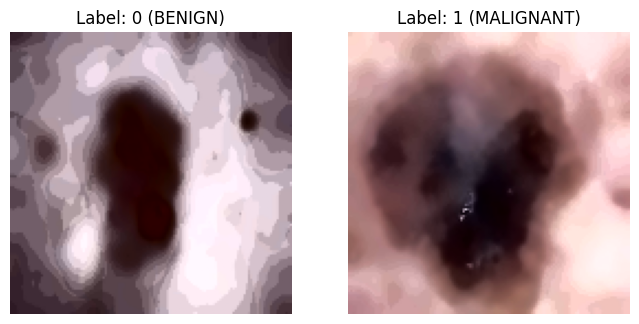

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_resnet50_model(input_shape):
    # ResNet50 모델을 생성, 사전학습된 ImageNet 가중치를 사용, include_top=False로 설정하여 최상위 층을 제거
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 사전학습된 가중치는 고정

    # 완전 연결 계층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # 입력과 출력을 지정하여 모델 생성
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# 모델 생성
model = create_resnet50_model(input_shape=(128, 128, 3))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # 다중 클래스 분류를 위한 손실 함수
              metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 16:22:02.007756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5444

2024-07-10 16:22:10.231863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 15s 191ms/step - loss: 0.6950 - accuracy: 0.5444 - val_loss: 0.6813 - val_accuracy: 0.6050
Epoch 2/50
50/50 [==============================] - 7s 141ms/step - loss: 0.6744 - accuracy: 0.5638 - val_loss: 0.6722 - val_accuracy: 0.5550
Epoch 3/50
50/50 [==============================] - 7s 140ms/step - loss: 0.6618 - accuracy: 0.6288 - val_loss: 0.6645 - val_accuracy: 0.6250
Epoch 4/50
50/50 [==============================] - 7s 139ms/step - loss: 0.6528 - accuracy: 0.6237 - val_loss: 0.6560 - val_accuracy: 0.5900
Epoch 5/50
50/50 [==============================] - 7s 138ms/step - loss: 0.6405 - accuracy: 0.6712 - val_loss: 0.6514 - val_accuracy: 0.7250
Epoch 6/50
50/50 [==============================] - 7s 140ms/step - loss: 0.6341 - accuracy: 0.6612 - val_loss: 0.6448 - val_accuracy: 0.6900
Epoch 7/50
50/50 [==============================] - 7s 135ms/step - loss: 0.6289 - accuracy: 0.6587 - val_loss: 0.6409 - val_accuracy: 0.6350
Epoch 8/50
50/50

In [ ]:
model = tf.keras.models.load_model('best_resnet_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 16:27:51.674826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 285ms/step - loss: 0.5779 - accuracy: 0.6800
Test Accuracy: 0.6800


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 16:27:55.357181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 328ms/step


#### 결과 확인

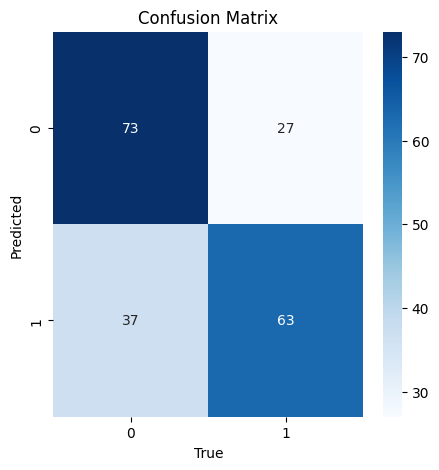

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

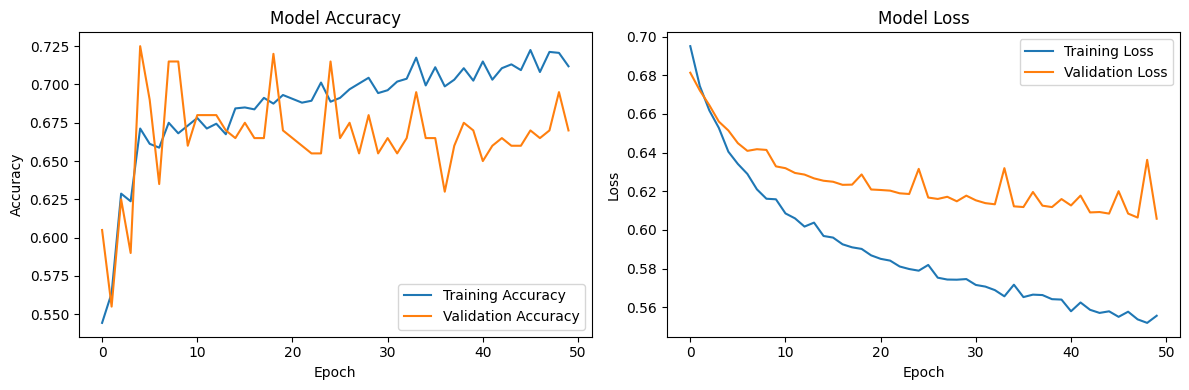

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

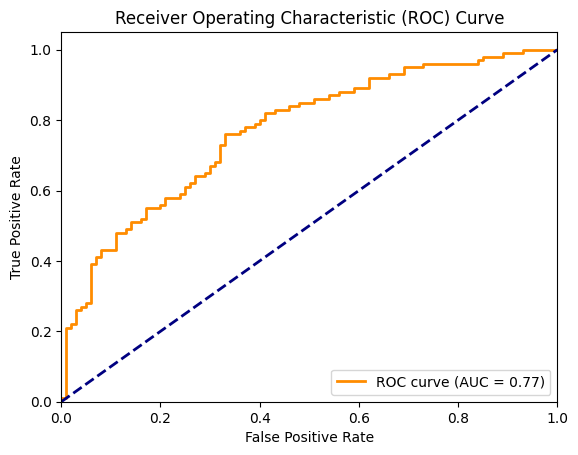

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/RGB'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            
            image = cv2.imread(image_path)  # color로 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            
            images.append(image)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

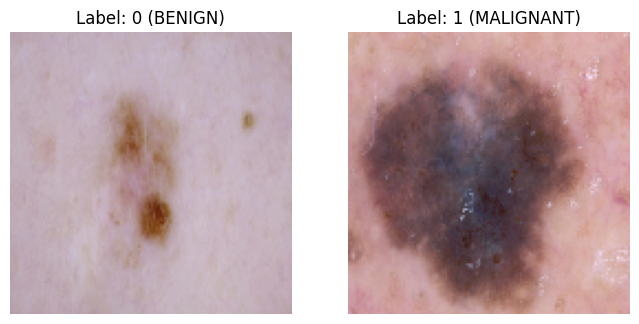

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_resnet50_model(input_shape):
    # ResNet50 모델을 생성, 사전학습된 ImageNet 가중치를 사용, include_top=False로 설정하여 최상위 층을 제거
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 사전학습된 가중치는 고정

    # 완전 연결 계층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # 입력과 출력을 지정하여 모델 생성
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# 모델 생성
model = create_resnet50_model(input_shape=(128, 128, 3))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # 다중 클래스 분류를 위한 손실 함수
              metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 23:27:50.944744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5025

2024-07-10 23:28:06.790949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 31s 430ms/step - loss: 0.6980 - accuracy: 0.5025 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 7s 138ms/step - loss: 0.6941 - accuracy: 0.5019 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 8s 163ms/step - loss: 0.6878 - accuracy: 0.5819 - val_loss: 0.6869 - val_accuracy: 0.6000
Epoch 4/50
50/50 [==============================] - 8s 157ms/step - loss: 0.6832 - accuracy: 0.5519 - val_loss: 0.6868 - val_accuracy: 0.5150
Epoch 5/50
50/50 [==============================] - 7s 135ms/step - loss: 0.6847 - accuracy: 0.5594 - val_loss: 0.6868 - val_accuracy: 0.5000
Epoch 6/50
50/50 [==============================] - 7s 145ms/step - loss: 0.6781 - accuracy: 0.5831 - val_loss: 0.6802 - val_accuracy: 0.6550
Epoch 7/50
50/50 [==============================] - 7s 138ms/step - loss: 0.6738 - accuracy: 0.6025 - val_loss: 0.6835 - val_accuracy: 0.5000
Epoch 8/50
50/50

In [ ]:
model = tf.keras.models.load_model('best_resnet_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 23:34:06.699361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 10s 905ms/step - loss: 0.6012 - accuracy: 0.7300
Test Accuracy: 0.7300


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 23:34:17.258067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 18s 2s/step


#### 결과 확인

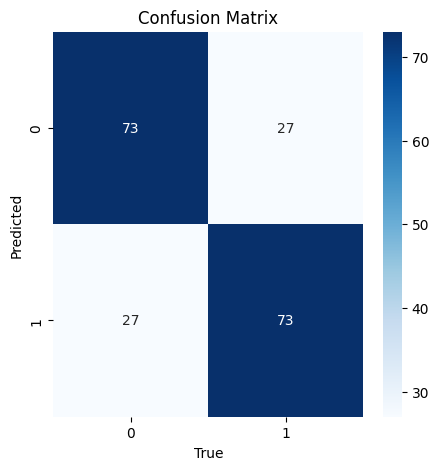

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

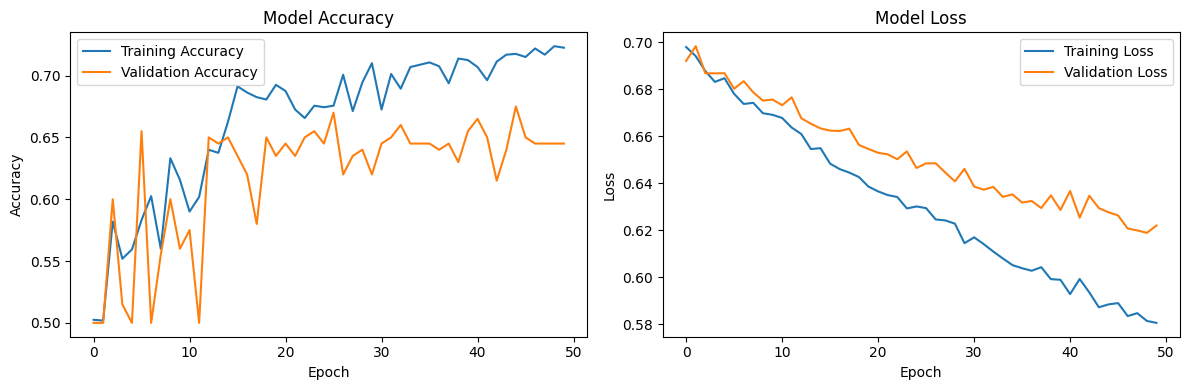

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

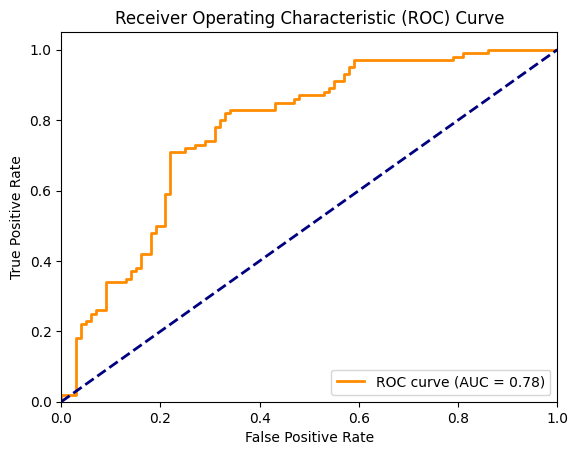

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [13]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/BGR'

In [14]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [16]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [17]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_rgb = cv2.imread(image_path)
            
            # # 노이즈 제거
            # image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # # YUV 컬로 포맷으로 변환
            # image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # # 히스토그램 평활화 적용
            # image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # # #RGB로 변환
            # image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [18]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

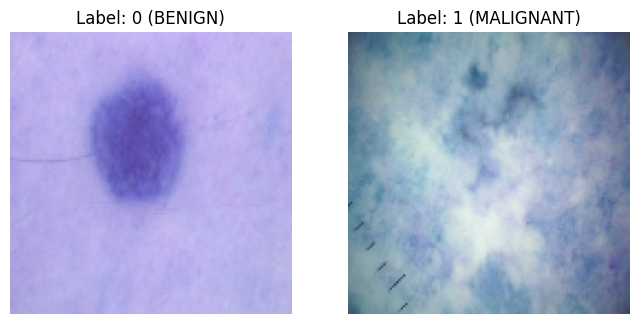

In [19]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [20]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [22]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [23]:
def create_VGG_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape) # 사전학습된 imagenet 사용
    # include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 사전학습된 가중치는 고정

    # 완전 연결 계층
    x = base_model.output # base_model의 출력값
    x = GlobalAveragePooling2D()(x) # Pooling 시킴
    x = Dense(1024, activation='relu')(x) # 완전연결층
    output = Dense(1, activation='sigmoid')(x) # 출력값 생성

    model = Model(inputs=base_model.input, outputs=output)

    return model

In [24]:
# Inception 용 전처리
# X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train)
# X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val)
# X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test)

model = create_VGG_model((128, 128, 3)) # 3: RGB
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_ResNet50_model.h5', save_best_only=True)
]

#### 학습

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 21:02:56.629474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 21:02:58.300003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5094

2024-07-10 21:03:06.408772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 12s 191ms/step - loss: 0.6997 - accuracy: 0.5094 - val_loss: 0.6919 - val_accuracy: 0.5050
Epoch 2/50
50/50 [==============================] - 8s 154ms/step - loss: 0.6907 - accuracy: 0.5175 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 7s 138ms/step - loss: 0.6892 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 4/50
50/50 [==============================] - 8s 155ms/step - loss: 0.6867 - accuracy: 0.5381 - val_loss: 0.6863 - val_accuracy: 0.6050
Epoch 5/50
50/50 [==============================] - 7s 139ms/step - loss: 0.6835 - accuracy: 0.5506 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/50
50/50 [==============================] - 8s 153ms/step - loss: 0.6800 - accuracy: 0.5956 - val_loss: 0.6841 - val_accuracy: 0.5200
Epoch 7/50
50/50 [==============================] - 7s 147ms/step - loss: 0.6771 - accuracy: 0.5731 - val_loss: 0.6821 - val_accuracy: 0.5850
Epoch 8/50
50/50

In [26]:
model = tf.keras.models.load_model('best_ResNet50_model.h5')

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 21:09:10.356652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 184ms/step - loss: 0.6121 - accuracy: 0.6950
Test Accuracy: 0.6950


In [28]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 21:09:13.054438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 241ms/step


#### 결과

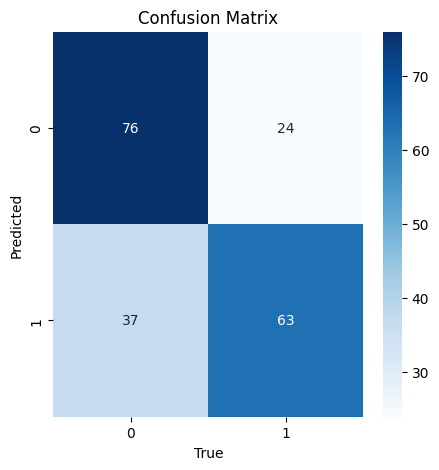

In [29]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

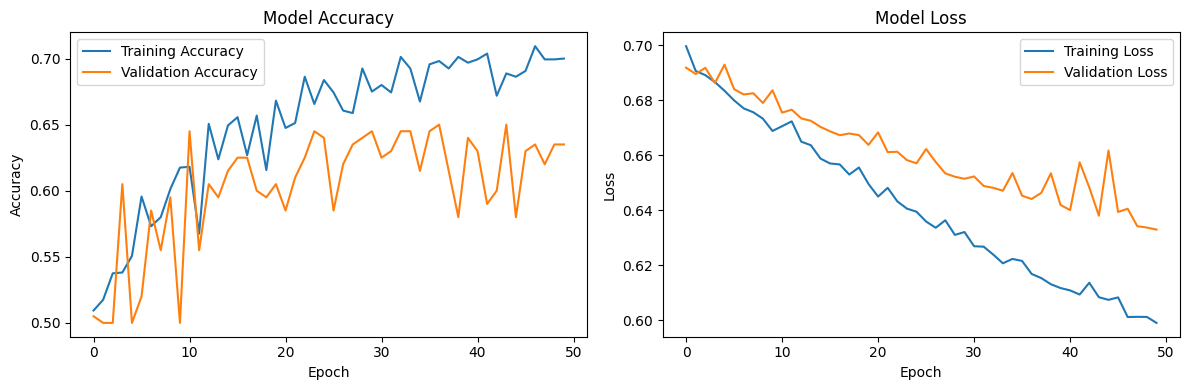

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

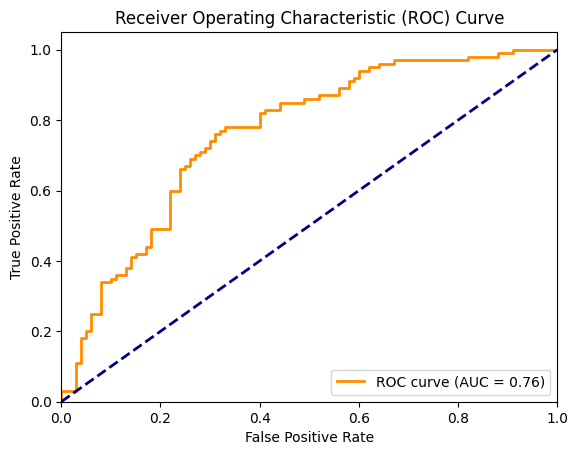

In [31]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()